# But de ce notebook

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

### Les données
Voici les données dont vous aurez besoin pour réaliser le dashboard. Pour plus de simplicité, vous pouvez les télécharger à cette adresse.

Vous aurez sûrement besoin de joindre les différentes tables entre elles.

### Votre mission
1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
2. Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.

Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Vous pourrez ainsi vous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.

### Spécifications du dashboard
Michaël vous a fourni des spécifications pour le dashboard interactif. Celui-ci devra contenir au minimum les fonctionnalités suivantes :

* Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
* Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
* Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

**Livrables**
* Le dashboard interactif répondant aux spécifications ci-dessus et l’API de prédiction du score, déployées chacunes sur le cloud.
* Un dossier sur un outil de versioning de code contenant :
    * Le code de la modélisation (du prétraitement à la prédiction)
    * Le code générant le dashboard
    * Le code permettant de déployer le modèle sous forme d'API
* Une note méthodologique décrivant :
    * La méthodologie d'entraînement du modèle (2 pages maximum)
    * La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
    * L’interprétabilité globale et locale du modèle (1 page maximum)
    * Les limites et les améliorations possibles (1 page maximum)
* Un support de présentation pour la soutenance, détaillant le travail réalisé.

On cherche ici à modéliser la probabilité qu'une personne rembourse ou non un emprunt contracté auprès de l'institution HomeCredit à partir d'une large base de données de ses clients.\
Conformément aux instructions, on ne cherchera pas ici à réaliser le _feature engineering_ de zéro, mais on se servira au contraire du kernel Lightgbm_with_simple_features. Ce kernel permet en principe de réaliser toute la chaîne de modélisation et de prédiction, mais nous ne réutiliserons ici que la partie _feature engineering_, qu'on va chercher à compléter ici de manière à appliquer d'autres modèles que celui proposé dans le kernel (LightGBM).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import lightgbm_with_simple_features as lgbmsf
import json
import seaborn as sns
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

import p7

import random

from lime import lime_tabular
import shap
shap.initjs()

from lightgbm import LGBMClassifier

from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

with open('config.json', 'r') as f:
    config = json.load(f)
    
NUM_ROWS = config["NUM_ROWS"]
PATH = config["PATH"]

## I. Création de la table finale

In [3]:
# liste des fichiers
os.listdir(PATH)

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'home_credit.png',
 'HomeCredit_columns_description.csv',
 'imputer_selection.py',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'Projet+Mise+en+prod+-+home-credit-default-risk.zip',
 'sample_submission.csv']

Il y a 9 fichiers, et on sait par la description donnée sur kaggle qu'ils sont liés entre eux via le schéma suivant

![home_credit](./data/home_credit.png)

Le jeu de données est contitué de 9 tables. Les descriptions sont les suivantes:

* **application_{train|test}.csv**\
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

* **bureau.csv**\
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.



* **bureau_balance.csv**\
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.


* **POS_CASH_balance.csv**\
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.


* **credit_card_balance.csv**\
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.


* **previous_application.csv**\
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.


* **installments_payments.csv**\
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

# I Analyse exploratoire

Tout le feature engineering ainsi que la jointure des différentes tables entre elles est réalisé par la fonction lgbmsf.join_df. On va donc reprendre ce code en l'adaptant de manière à pouvoir explorer:
- les associations entre les variables catégorielles et la cible grâce à des tests du chi2
- les corrélations entre les variables numériques et la cible grâce à deux méthodes:
    - ANOVA
    - Corrélations de Pearson/Spearman
    
Ceci permettra de dégager quelques informations à propos du jeu de données et ainsi de contrôler la pertinence du modèle développé ensuite. Cela permettra également une comparaison avec les résultats obtenus avec les différentes  interprétations données par LIME et/ou SHAP.

## I.1 Jointures des tables

**Jointures sans prétraitement**

Pour pouvoir réaliser les tests du chi2 sur les variables catégorielles, il est nécessaire de réaliser les jointures **sans** prétraitement. En effet, chaque fonction de prétraitement inclut la transformation des variables catégorielles en _dummies_.

In [5]:
raw_df = lgbmsf.join_raw_df(num_rows=50000)

# filtre le jeu de données pour ne garder qu'un sous-ensemble sans valeurs manquantes
cleaned_df = p7.dropna_cols(raw_df, 0.8)
cleaned_df.dropna(how='any', inplace=True)

Train samples: 50000
Bureau df shape: (71704, 18)
Process bureau and bureau_balance - done in 3s
Previous applications df shape: (50000, 37)
Process previous_applications - done in 2s
Pos-cash balance df shape: (50000, 8)
Process POS-CASH balance - done in 1s
Installments payments df shape: (50000, 8)
Process installments payments - done in 1s
Credit card balance df shape: (50000, 23)
Process credit card balance - done in 1s


On sait que les classes sont très déséquilibrées. On vérifie que le nettoyage opéré sur les tables n'altère pas trop le rapport entre nombre de clients de classe 0 et nombre de clients de classe 1.

In [7]:
# taille des classes
print("Avant nettoyage: {:.3f}".format(raw_df.TARGET.value_counts()[1]/raw_df.TARGET.value_counts()[0]))
print("Après nettoyage: {:.3f}".format(cleaned_df.TARGET.value_counts()[1]/cleaned_df.TARGET.value_counts()[0]))
print("Taille du jeu de données original: {}".format(raw_df.shape))
print("Taille du jeu de données nettoyé: {}".format(cleaned_df.shape))

Avant nettoyage: 0.083
Après nettoyage: 0.081
Taille du jeu de données original: (74395, 211)
Taille du jeu de données nettoyé: (61395, 72)


Enfin, on peut réaliser les tests d'indépendance du chi2.

In [9]:
# Tests du chi2 sur les variables catégorielles
cat_cols = [col for col in cleaned_df.columns if cleaned_df[col].dtype=='object']
stats = {}
for f in cat_cols:
    chi2, pval = p7.chi2_test(f, 'TARGET', cleaned_df)
    stats[f] = [chi2, pval]

chi2_results = pd.DataFrame.from_dict(stats, orient='index', columns=['chi2 score', 'p value'])

chi2_results[chi2_results['p value']<5e-2].sort_values(by='chi2 score', ascending=False)

,chi2 score,p value
ORGANIZATION_TYPE,375.458693,2.004583e-48
NAME_EDUCATION_TYPE,206.149110,1.789098e-43
CODE_GENDER,192.145235,1.888828e-42
NAME_INCOME_TYPE,170.808778,4.903818e-35
NAME_HOUSING_TYPE,77.794731,2.426445e-15
NAME_FAMILY_STATUS,55.508327,2.542265e-11
NAME_CONTRACT_TYPE,49.444580,2.040556e-12
WEEKDAY_APPR_PROCESS_START,30.458649,3.215178e-05


Les variables retenues ci-dessus sont celles qui, en principe, présentent une association avec la variable cible.

On passe maintenant aux variables numériques. Comme le prétraitement génère beaucoup de nouvelles variables numériques, il est plus intéressant cette fois-ci d'étudier les dépendances/corrélations à partir de la table finale. On réalise donc les jointures avec la fonction "standard" du module lgbmsf.

In [ ]:
del raw_df

**Jointures avec prétraitement**

In [10]:
df = lgbmsf.join_df(num_rows=50000)

# filtre le jeu de données pour ne garder qu'un sous-ensemble sans valeurs manquantes
cleaned_df = p7.dropna_cols(df, 0.8)
cleaned_df.dropna(how='any', inplace=True)

Train samples: 50000
Bureau df shape: (10171, 111)
Process bureau and bureau_balance - done in 3s
Previous applications df shape: (44471, 246)
Process previous_applications - done in 5s
Pos-cash balance df shape: (42556, 15)
Process POS-CASH balance - done in 1s
Installments payments df shape: (32256, 26)
Process installments payments - done in 1s
Credit card balance df shape: (34417, 131)
Process credit card balance - done in 4s


In [11]:
# taille des classes
print("Avant nettoyage: {:.3f}".format(df.TARGET.value_counts()[1]/df.TARGET.value_counts()[0]))
print("Après nettoyage: {:.3f}".format(cleaned_df.TARGET.value_counts()[1]/cleaned_df.TARGET.value_counts()[0]))
print("Taille du jeu de données original: {}".format(df.shape))
print("Taille du jeu de données nettoyé: {}".format(cleaned_df.shape))

Avant nettoyage: 0.088
Après nettoyage: 0.091
Taille du jeu de données original: (49998, 776)
Taille du jeu de données nettoyé: (32795, 202)


Le prétraitement crée des variables encodées _one-hot_. On écarte ces variables des variables numériques avant de réaliser l'ANOVA.

In [12]:
num_cols = [col for col in cleaned_df.columns if cleaned_df[col].nunique()>2]

In [14]:
# Test Anova sur les variables continues/numériques
results = {}
for col in num_cols:
    F_score, p_value, eta_sq = p7.anova(cleaned_df, col, 'TARGET')
    results[col] = [F_score, p_value, eta_sq]
anova_df = pd.DataFrame.from_dict(results, orient='index', columns=['F-score', 'p-value', 'eta-squared'])

anova_df[anova_df['p-value']<5e-2].sort_values(by='eta-squared', ascending=False)[1:10]

,F-score,p-value,eta-squared
EXT_SOURCE_2,884.825196,6.964408e-192,0.026273
DAYS_EMPLOYED,206.575140,1.064530e-46,0.006260
DAYS_BIRTH,180.114300,5.870394e-41,0.005462
REGION_RATING_CLIENT_W_CITY,171.335952,4.735579e-39,0.005198
DAYS_EMPLOYED_PERC,166.762981,4.667295e-38,0.005060
REGION_RATING_CLIENT,165.157984,1.042068e-37,0.005011
DAYS_LAST_PHONE_CHANGE,123.682339,1.112755e-28,0.003757
AMT_GOODS_PRICE,88.902357,4.410955e-21,0.002704
DEF_60_CNT_SOCIAL_CIRCLE,67.409474,2.285840e-16,0.002051


Enfin, on peut croiser ces résultats avec une analyse des corrélations (non-linéaires)

In [15]:
corr = cleaned_df.corr(method='spearman')['TARGET']
corr.sort_values(ascending=False)[1:10]

DAYS_EMPLOYED                                        0.081961
DAYS_BIRTH                                           0.073667
REGION_RATING_CLIENT_W_CITY                          0.072098
REGION_RATING_CLIENT                                 0.070734
NAME_EDUCATION_TYPE_Secondary / secondary special    0.063375
DAYS_LAST_PHONE_CHANGE                               0.059249
PAYMENT_RATE                                         0.042990
FLAG_DOCUMENT_3                                      0.041820
DEF_60_CNT_SOCIAL_CIRCLE                             0.041130
Name: TARGET, dtype: float64

In [ ]:
del df

# II Préparation du jeu de données

In [2]:
df = lgbmsf.join_df(num_rows=50000)

# On retire les colonnes ayant moins 75% de leurs valeurs
cleaned_df = p7.dropna_cols(df, 0.75)

# On réalise des imputations pour combler les trous grâce à la méthode SimpleImputer
# la méthode IterativeImputer étant trop longue avec ce jeu de données.
filled_data = p7.impute(cleaned_df, iterative=False, strategy='mean')

Train samples: 50000
Bureau df shape: (10171, 111)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (44471, 246)
Process previous_applications - done in 3s
Pos-cash balance df shape: (42556, 15)
Process POS-CASH balance - done in 1s
Installments payments df shape: (32256, 26)
Process installments payments - done in 1s
Credit card balance df shape: (34417, 131)
Process credit card balance - done in 3s


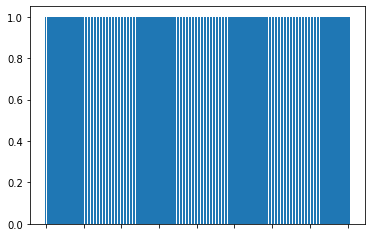

In [4]:
nna = filled_data.notna().sum()/filled_data.shape[0]
fig, ax = plt.subplots()
ax.bar(x=np.arange(len(filled_data.columns)), height=nna)
ax.set_xticklabels('')
plt.show()

In [ ]:
filled_data.to_csv('./data/filled_data.csv', index_label=False)
del df

## I.3 Prédictions

### I.3.1 Préparation des jeux de données

In [33]:
feats = filled_data.drop(columns=['SK_ID_CURR', 'TARGET']).columns
X = filled_data.drop(columns=['SK_ID_CURR', 'TARGET']).to_numpy()
y = filled_data.TARGET.to_numpy()

# Séparation en jeux d'entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

### I.3.2 Baselines - Classification naïves avec DummyClassifier

Pour pouvoir interpréter les résultats obtenus, on va comparer les scores de prédiction avec les scores obtenus par des approches naïves. Elles sont implémentées dans la classe  DummyClassifier  du module  dummy  de scikit-learn.

1. Prédire la même classe pour tous les échantillons : la classe la plus fréquente dans le jeu d'entraînement. Cette approche naïve nous permet d’évaluer si le modèle que nous proposons a appris « plus » que simplement quelle est la classe la plus fréquente. C’est particulièrement intéressant si une des classes est beaucoup plus fréquente que les autres. Pensez que pour un problème de classification binaire sur des données contenant 90% d’échantillons positifs, un classifieur qui retourne systématiquement « positif » aura une accuracy de 90%.

2. Prédire une classe aléatoirement, dans les mêmes proportions que dans le jeu d'entraînement. Cette approche naïve nous permet d’évaluer si les performances que nous observons ne seraient pas simplement dûes aux proportions relatives des classes.

3. Retourner aléatoirement des scores selon une distribution uniforme, puis leur appliquer un seuil pour obtenir une prédiction binaire. Cette méthode est recommandée quand on cherche à interpréter une courbe ROC ou une AUROC, elles-mêmes construites à partir de classifieurs qui retournent des scores.

**1. La classe majoritaire est prédite systématiquement**

In [34]:
dummyclf = DummyClassifier(strategy='most_frequent',)
dummyclf.fit(X_train, y_train)
y_pred = dummyclf.predict(X_test)
print("AUROC Score : {:.2f}".format(roc_auc_score(y_test, y_pred)))

AUROC Score : 0.50


**2. Les étiquettes sont prédites aléatoirement parmi {0, 1}**

In [35]:
dummyclf = DummyClassifier(strategy='uniform')
dummyclf.fit(X_train, y_train)
y_pred = dummyclf.predict(X_test)
print("AUROC Score : {:.2f}".format(roc_auc_score(y_test, y_pred)))

AUROC Score : 0.50


### I.3.2 Prédictions avec LightGBM

In [36]:
# Séparation en jeux d'entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)


# Création du pipeline
model = LGBMClassifier(objective='binary', metric='AUC', is_unbalance=True)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Evaluation du modèle
print("\nPerformance sur le jeu de test' : {:.3f}".format(roc_auc_score(y_test, y_pred)))


Performance sur le jeu de test' : 0.622


On obtient déjà des performances en légère amélioration par rapport à une classification naïve. Pour aller plus loin, on va chercher à:
- "améliorer" le jeu de données
- optimiser les hyperparamètres

In [16]:
# Séparation en jeu d'entraînement/validation pour la recherche sur grille
X_val_train, X_val_val, y_val_train, y_val_val = \
train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)

# Nested cross-validation pour la validation du (des) hyperparamètre(s) par GridSearch
#inner_cv = StratifiedKFold(n_splits=5).split(X_train, y_train)

# Hyperparamètre(s) à optimiser
param_grid = {"n_estimators" : [100, 1000, 10000],
              "max_depth" : [-1, 5, 10], 
              "colsample_bytree" : [0.5, 0.8, 1],
              "num_leaves" : [10, 30, 50],
             }    

#for params in ParameterGrid(param_grid):
model = LGBMClassifier(early_stopping_round=200,
                               objective='binary',
                               metric='AUC',
                               is_unbalance=True,
                               silent=False,
                               verbosity=-1,
                              )

# Régression avec sélection d'(des)hyperparamètre(s) par validation croisée
regr = GridSearchCV(
estimator=model,            # modèle
param_grid=param_grid,     # hyperparamètres à tester
cv=5,    # nombre de folds de validation croisée
scoring='roc_auc',   # score à optimiser
return_train_score=True,
)

# Optimisation de l'estimateur sur le jeu d'entraînement
regr.fit(X=X_train, y=y_train, eval_set=(X_val_val, y_val_val), verbose=-1)

# Afficher le(s) hyperparamètre(s) optimaux
print("\nMeilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(regr.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'colsample_bytree': 0.5, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 10}


In [19]:
bestmodel = LGBMClassifier(early_stopping_round=200,
                               objective='binary',
                               metric='AUC',
                               is_unbalance=True,
                               silent=False,
                               verbosity=-1,
                           **regr.best_params_)

bestmodel.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=-1)

# On sauvegarde le meilleur modèle
with open('fitted_lgbm.pickle', 'wb') as f:
    pickle.dump(bestmodel, f)
    
y_pred = bestmodel.predict(X_test)

# Performance sur le jeu d'entraînement
print("\nMeilleure performance sur le jeu d'entraînement/validation' : {:.3f}".format(regr.best_score_))

# Performance en généralisation du meilleur modèle sur le jeu de test
y_pred = regr.predict(X_test)
print("Performance en généralisation sur le jeu de test : {:.3f}".format(roc_auc_score(y_test, y_pred)))


Meilleure performance sur le jeu d'entraînement/validation' : 0.737
Performance en généralisation sur le jeu de test : 0.656


## I.3 Interprétabilité du modèle

### 1.3.1 Matrice de confusion et rapport

In [37]:
with open('./fitted_lgbm.pickle', 'rb') as f:
    bestmodel = pickle.load(f)

In [38]:
print("Confusion Matrix : ")
print(confusion_matrix(y_test, bestmodel.predict(X_test)))
print()
print("Classification Report")
print(classification_report(y_test, bestmodel.predict(X_test)))

Confusion Matrix : 
[[3049 1099]
 [  84  268]]

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      4148
           1       0.20      0.76      0.31       352

    accuracy                           0.74      4500
   macro avg       0.58      0.75      0.57      4500
weighted avg       0.91      0.74      0.80      4500



Le mauvais score de précision pour la classe minoritaire indique probablement un sous-apprentissage, d'autant plus que la performance globale de l'estimateur est plutôt basse sur le jeu de test.

### I.3.2. LIME

In [43]:
explainer = lime_tabular.LimeTabularExplainer(X_train, mode="classification",
                                              class_names=[0, 1],
                                              feature_names=filled_data.drop(columns=['TARGET','SK_ID_CURR']),
                                             )

idx = random.randint(1, len(X_test))

print("Prediction : ", bestmodel.predict(X_test[idx].reshape(1,-1))[0])
print("Actual :     ", y_test[idx])

explanation = explainer.explain_instance(X_test[idx], bestmodel.predict_proba,
                                         num_features=10)

explanation.show_in_notebook()

Prediction :  0
Actual :      0


**Interprétation locale de prédictions incorrectes**

In [44]:
preds = bestmodel.predict(X_test)

false_preds = np.argwhere((preds != y_test)).flatten()

idx  = random.choice(false_preds)

print("Prediction : ", bestmodel.predict(X_test[idx].reshape(1,-1))[0])
print("Actual :     ", y_test[idx])

explanation = explainer.explain_instance(X_test[idx], bestmodel.predict_proba)

explanation.show_in_notebook()

Prediction :  1
Actual :      0


On peut comparer avec les _feature importances_ calculées directement via l'api de LGBMClassifier

In [59]:
perm_importance = permutation_importance(bestmodel, X_test, y_test, n_repeats=10, random_state=0)
feature_importance = pd.DataFrame(data=bestmodel.feature_importances_, index=feats, columns=['Feature_importance'])

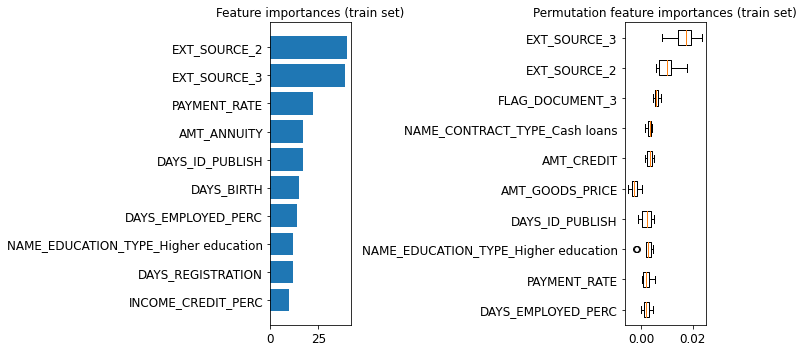

In [83]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
f = feature_importance["Feature_importance"].sort_values(ascending=False)[:10]
ax1.barh(f.index, f)
ax1.set_title("Feature importances (train set)")
ax1.invert_yaxis()
ax1.tick_params(axis='both', which='major', labelsize=12)

sorted_idx = np.abs(perm_importance.importances_mean).argsort()[::-1][:10]
importances_array = perm_importance.importances[sorted_idx]
ax2.boxplot(importances_array.T, vert=False, labels=feats[sorted_idx])
ax2.set_title("Permutation feature importances (train set)")
ax2.invert_yaxis()
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.subplots_adjust(left=0.3, right=0.99)
fig.tight_layout()
#plt.savefig('./feat_importancesrfr_selected', dpi=300)
plt.show()

Les variables _PAYMENT_RATE, DAYS_EMPLOYED, DAYS_ID_PUBLISH, ANNUITY_INCOME_PERC, INCOME_CREDIT_PERC, DAYS_LAST_PHONE_CHANGE_, se retrouvent à chaque fois parmi les 10 variables les plus importantes ce qui suggère que ces variable sont effectivement déterminantes par rapport au résultat des prédictions.

**3. Robustesse de l'analyse par LIME**

In [49]:
idx = random.randint(1, len(X_test))
explanation = explainer.explain_instance(X_test[idx], bestmodel.predict_proba,
                                         num_features=10)
actual_pred = bestmodel.predict_proba(X_test[idx].reshape(1,-1))
perc_pred_diff =  abs(actual_pred[0][1] - explanation.local_pred[0])

print("lime class1: {:.3f}".format(explanation.local_pred[0]))
print("actual class1: {:.3f}".format(actual_pred[0][1]))
print("class_diff: {:.3f}".format(round(perc_pred_diff,3)))
print("model : LightGBM")

lime class1: 0.204
actual class1: 0.150
class_diff: 0.053
model : LightGBM


Les deux prédictions sont remarquablement en accord, LIME approxime bien le modèle LGBM sur ce dataset. 

### I.3.3 SHAP

Base Value: 0.390
Prediction From Model: [0 0 1 0 0]
Prediction From Adding SHAP Values to Base Value: 0.543


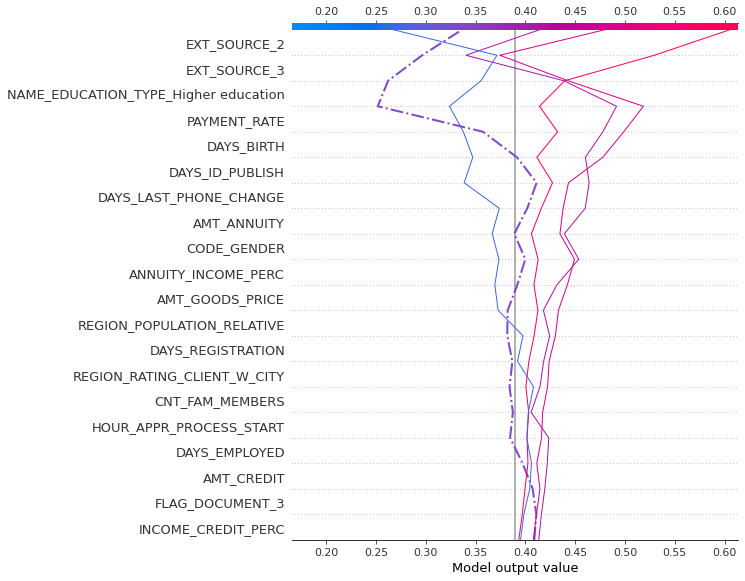

In [99]:
bg_data_indices = np.random.choice(X_train.shape[0], 1000, replace=False)
bg_data = X_train[bg_data_indices]

tree_explainer1 = shap.TreeExplainer(bestmodel,
                                     data=bg_data,
                                     feature_perturbation='interventional',
                                     model_output='probability'
                                    )

sample_idx = np.random.choice(len(X_test), 5)
shap_vals = tree_explainer1.shap_values(X_test[sample_idx])
base_value = tree_explainer1.expected_value
                  #key=lambda tuple: tuple[0], 
                  #reverse=True)
print("Base Value: {:.3f}".format(base_value))
print("Prediction From Model: {}".format(bestmodel.predict(X_test[sample_idx])))
print("Prediction From Adding SHAP Values to Base Value: {:.3f}".format(tree_explainer1.expected_value + shap_vals.sum()))

shap.decision_plot(base_value,
                   tree_explainer1.shap_values(X_test[sample_idx]),
                   #row_index=X_test[:10],
                   feature_names=feats.to_list(),
                   highlight = [1]
                  )

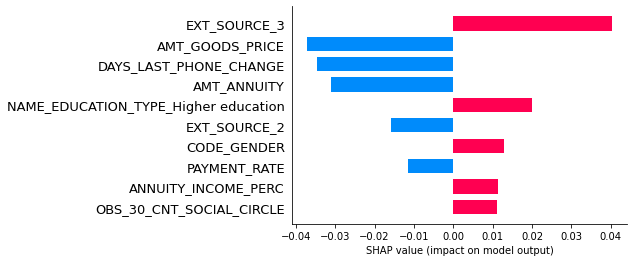

In [103]:
shap.bar_plot(tree_explainer1.shap_values(X_test[0]), feature_names=feats.to_list(), max_display=10)

In [106]:
shap.force_plot(tree_explainer1.expected_value,
                tree_explainer1.shap_values(X_test[0]),
                feature_names=feats.to_list(),
                #out_names="Chance of default"
               )